In [1]:
import numpy as np
import json
import tensorflow as tf
import matplotlib.pyplot as plt

with open('../src/dataset/MPII/mpii_human_pose_v1_u12_1.json', 'r') as json_file:
    data = json.load(json_file)

search_idx = 10
keypoints = data[search_idx]['joint_self']
print(data[search_idx]['img_paths'])
image = tf.io.read_file(filename='./061185289.jpg')
image = tf.io.decode_image(image, channels=3)
image_height, image_width, image_channel = image.shape[:3]
target_width = 256
target_height = 256 
num_keypoints = 14  
variance = 25.0
peak_value = 1.0

import numpy as np

def generate_heatmap(keypoint_x, keypoint_y, image_width, image_height, peak_value = 1.0, variance = 1.0):

    target_x = keypoint_x // target_width
    target_y = keypoint_y // target_height

    x = np.arange(0, target_height, 1)
    y = np.arange(0, target_width, 1)
    xv, yv = np.meshgrid(x, y)

    # Calculate the squared distance from each pixel to the keypoint
    distance_squared = (xv - target_x)**2 + (yv - target_y)**2

    # Create a heatmap with zeros
    heatmap = np.zeros((target_height, target_width),dtype=np.float32)

    # Set the value at the keypoint to the peak_value
    heatmap[int(target_y), int(target_x)] = peak_value

    # Optionally, apply Gaussian smoothing to the peak
    heatmap = peak_value * np.exp(-distance_squared / (2.0 * variance ** 2))

    return heatmap



061185289.jpg


In [2]:
heatmaps = np.zeros((num_keypoints, target_height, target_width))

for i in range(num_keypoints):
    keypoint_x, keypoint_y, visibility = keypoints[i]  # Replace with your actual keypoint data
    if visibility > 0.5:  # You can adjust this threshold based on your dataset
        heatmap = generate_heatmap(keypoint_x, keypoint_y, target_height, target_width, peak_value ,variance)
        heatmaps[i] = heatmap


In [3]:
ground_truth_heatmap = np.stack(heatmaps, axis=-1)
print(ground_truth_heatmap.shape)

(256, 256, 14)


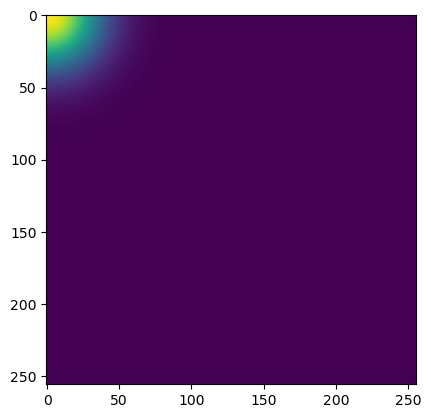

In [4]:
import matplotlib.pyplot as plt
vis = np.zeros((target_height, target_width))

for idx in range(ground_truth_heatmap.shape[-1]):
    vis += ground_truth_heatmap[:,:,idx]

plt.imshow(vis)

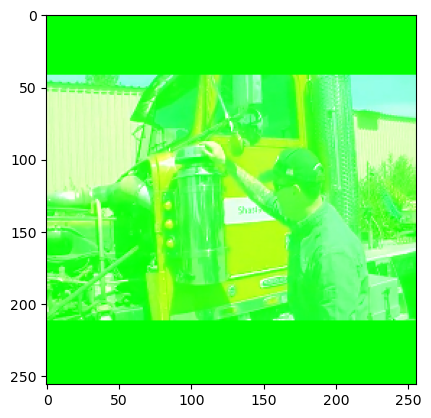

In [5]:
image_resized_ndrr = tf.image.resize_with_pad(image, target_height, target_width).numpy()
vis_mask = np.zeros_like(vis, dtype=np.int32)
vis_mask[vis > 0] = 1
image_resized_ndrr[vis_mask == 1,1] = 255
plt.imshow(tf.cast(image_resized_ndrr, dtype=tf.uint8))